## Import and install dependencies

In [1]:
!pip install causal-conv1d>=1.2.0
!pip install mamba-ssm
!pip install trl
!pip install peft
!pip install accelerate

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 297.6 kB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 MB 9.0 MB/s eta 0:00:00:00:0100:01
  Created wheel for mamba-ssm: filename=mamba_ssm-1.2.0.post1-cp310-cp310-linux_x86_64.whl size=137581036 sha256=37a78248a6b0c9157d6408484d93dd1f9a9cc43cebcbd160c9312fb8bb690bac
  Stored in directory: /root/.cache/pip/wheels/22/6e/60/ddd5c574b5793a30028f2cabdacd2a3ec2276edaaa8c00fd35
Successfully built mamba-ssm
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.2/245.2 kB 2.0 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.0/102.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 2.1 MB/s eta 0:00:00a 0:00:01m


In [2]:
data_path = "/kaggle/input/squad0"

In [3]:
import numpy as np
import torch
import random
import gc
from datasets import Dataset
import json
import time
import pandas as pd

from datasets import load_dataset
from trl import SFTTrainer
from peft import LoraConfig, PeftConfig, get_peft_model
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments

import os

2024-05-08 23:45:23.787906: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 23:45:23.788012: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 23:45:23.921689: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Making the notebook deteministic

In [4]:
def fix_random(seed: int) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


fix_random(seed=42)

Load the squad dataset

In [5]:
dataset = load_dataset('squad', split='train')
dataset = dataset.shuffle(seed=42)
dataset = dataset.select(range(20000)) 

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Here we are creating the dataset for training. The question and answer pairs have the following format:

{context}

Q: {question}

A: {answer}

In [6]:
def making_Question_With_Context(dataset):
    answers = [answer['text'][0] for answer in dataset['answers']] 
    questions = [question for question in dataset['question']] 
    contexts = [context for context in dataset['context']]
    contexts_with_question = [f"{context}\n\nQ: {question}\n\nA: {answer}"for question, context, answer in zip(questions, contexts, answers)]

    return Dataset.from_dict({'contexts_with_question': contexts_with_question})

In [7]:
os.environ["WANDB_DISABLED"] = "true"

tokenizer = AutoTokenizer.from_pretrained("state-spaces/mamba-130m-hf", padding_side='left')
model = AutoModelForCausalLM.from_pretrained("state-spaces/mamba-130m-hf")
tokenizer.eos_token = "<|endoftext|>"
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/4.79k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/895 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/517M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [8]:
peft_config = LoraConfig(
        r=8,
        lora_alpha=16,
        lora_dropout=0.1,
        target_modules=["x_proj", "embeddings", "in_proj", "out_proj"],
        task_type="CAUSAL_LM",
        bias="none"
)


model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

datasetTrain = making_Question_With_Context(dataset)

training_args = TrainingArguments(
    output_dir="/kaggle/working",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    logging_dir='./logs',
    logging_steps=50,
    learning_rate=2e-4,
    fp16=not torch.cuda.is_bf16_supported(),
    bf16=torch.cuda.is_bf16_supported(),
    optim="adamw_torch_fused",
    weight_decay=0.01,
    lr_scheduler_type="linear"
)

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    peft_config=peft_config,
    train_dataset=datasetTrain,
    dataset_text_field="contexts_with_question",
)

trainable params: 1,898,304 || all params: 131,033,664 || trainable%: 1.4487147363901844


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:318: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [9]:
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 1,898,304 || all params: 131,033,664 || trainable%: 1.4487147363901844


In [10]:
model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PeftModelForCausalLM(
      (base_model): LoraModel(
        (model): MambaForCausalLM(
          (backbone): MambaModel(
            (embeddings): lora.Embedding(
              (base_layer): Embedding(50280, 768)
              (lora_dropout): ModuleDict(
                (default): Dropout(p=0.1, inplace=False)
              )
              (lora_A): ModuleDict()
              (lora_B): ModuleDict()
              (lora_embedding_A): ParameterDict(  (default): Parameter containing: [torch.cuda.FloatTensor of size 8x50280 (cuda:0)])
              (lora_embedding_B): ParameterDict(  (default): Parameter containing: [torch.cuda.FloatTensor of size 768x8 (cuda:0)])
            )
            (layers): ModuleList(
              (0-23): 24 x MambaBlock(
                (norm): MambaRMSNorm()
                (mixer): MambaMixer(
                  (conv1d): Conv1d(1536, 1536, kernel_size=(4,), stride=(1,), padding=(3,), groups=1536)
 

In [11]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
50,2.998400
100,2.902300
150,2.858000
200,2.850700
250,2.848600
300,2.847400
350,2.873900
400,2.848600
450,2.824400
500,2.821000


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=1250, training_loss=2.8341792724609376, metrics={'train_runtime': 1198.96, 'train_samples_per_second': 16.681, 'train_steps_per_second': 1.043, 'total_flos': 3678781736890368.0, 'train_loss': 2.8341792724609376, 'epoch': 1.0})

In [12]:
dt = pd.DataFrame(trainer.state.log_history)

In [13]:
dt

,loss,grad_norm,learning_rate,epoch,step,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,2.9984,118388.664062,0.000192,0.04,50,NaN,NaN,NaN,NaN,NaN
1,2.9023,82784.687500,0.000184,0.08,100,NaN,NaN,NaN,NaN,NaN
2,2.8580,67602.273438,0.000176,0.12,150,NaN,NaN,NaN,NaN,NaN
3,2.8507,66567.226562,0.000168,0.16,200,NaN,NaN,NaN,NaN,NaN
4,2.8486,69898.382812,0.000160,0.20,250,NaN,NaN,NaN,NaN,NaN
5,2.8474,67192.195312,0.000152,0.24,300,NaN,NaN,NaN,NaN,NaN
6,2.8739,60286.214844,0.000144,0.28,350,NaN,NaN,NaN,NaN,NaN
7,2.8486,74722.546875,0.000136,0.32,400,NaN,NaN,NaN,NaN,NaN
8,2.8244,65762.195312,0.000128,0.36,450,NaN,NaN,NaN,NaN,NaN
9,2.8210,62195.925781,0.000120,0.40,500,NaN,NaN,NaN,NaN,NaN


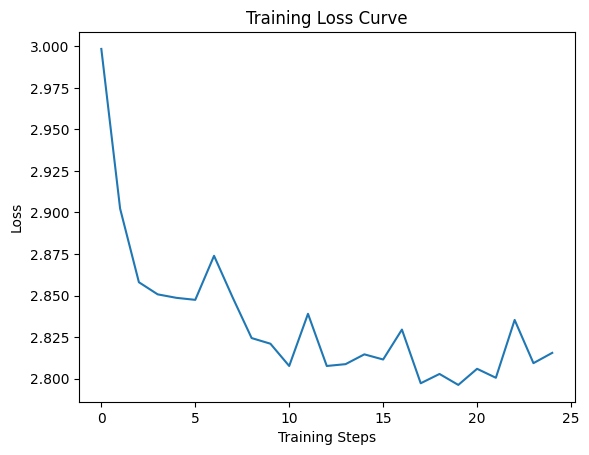

In [14]:
import matplotlib.pyplot as plt

plt.plot(dt['loss'])
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

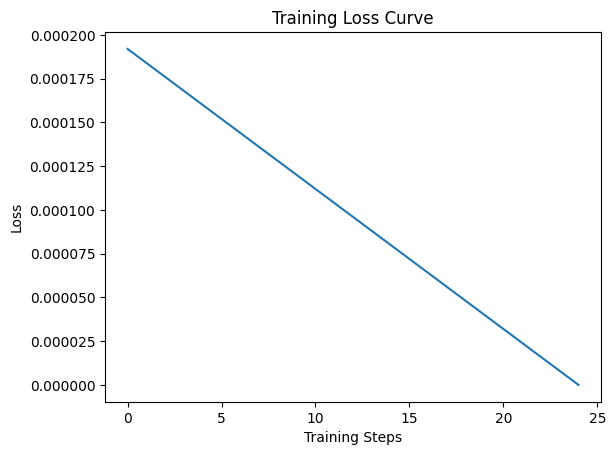

In [15]:
plt.plot(dt['learning_rate'])
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

In [16]:
def load(path):
    data = []
    with open(f"{data_path}/squad_val_1k.jsonl", "r") as file:
          for line in file:
              try:
                  data.append(json.loads(line))
              except Exception as e:
                  print("json processing exception", e)
                  continue
    return data

In [17]:
data = load('squad_val_1k.jsonl')
print(data[0])

{'context': 'The Panthers beat the Seattle Seahawks in the divisional round, running up a 31–0 halftime lead and then holding off a furious second half comeback attempt to win 31–24, avenging their elimination from a year earlier. The Panthers then blew out the Arizona Cardinals in the NFC Championship Game, 49–15, racking up 487 yards and forcing seven turnovers.', 'prompt': 'How many yards did the Panthers get for the division championshipt game?', 'response': '487'}


In [18]:
#This function generate the prompt. If we set the few_shot parameter to True, then it will generate
#a prompt, which uses few-shot prompting technique, otherwise not.
def generate_prompt(few_shot, question_with_context):
    questions = []
    if few_shot:
        three_shot_prompting = [
        {
            "context" : "In 1993, the FCC repealed the Financial Interest and Syndication Rules, once again allowing networks to hold interests in television production studios. That same year, Capital Cities/ABC purchased the French animation studio DIC Entertainment; it also signed an agreement with Time Warner Cable to carry its owned-and-operated television stations on the provider's systems in ABC O&O markets. By that year, ABC had a total viewership share of 23.63% of American households, just below the limit of 25% imposed by the FCC.",
            "question": "What French animation studio did ABC purchase in 1993?",
            "answer": "DIC Entertainment",
        },
        {
            "context" : "On April 12, 1961, Soviet cosmonaut Yuri Gagarin became the first person to fly in space, reinforcing American fears about being left behind in a technological competition with the Soviet Union. At a meeting of the US House Committee on Science and Astronautics one day after Gagarin's flight, many congressmen pledged their support for a crash program aimed at ensuring that America would catch up. Kennedy was circumspect in his response to the news, refusing to make a commitment on America's response to the Soviets.",
            "question": "How many days after Gagarin's flight did the US House Committee on Science and Astronautics meet?",
            "answer": "one day",
        },
        {
            "context" : "The customary law of Normandy was developed between the 10th and 13th centuries and survives today through the legal systems of Jersey and Guernsey in the Channel Islands. Norman customary law was transcribed in two customaries in Latin by two judges for use by them and their colleagues: These are the Très ancien coutumier (Very ancient customary), authored between 1200 and 1245; and the Grand coutumier de Normandie (Great customary of Normandy, originally Summa de legibus Normanniae in curia laïcali), authored between 1235 and 1245.",
            "question": "Where are Jersey and Guernsey?",
            "answer": "Channel Islands",
        }
        ]
        for item in question_with_context:
            prompt = f"You are a question answering bot. Your task is to answer the questions based on the appropriate contexts and your own knowledge. Your answers should contain only the most important things and should be as short as possible."
            prompt = f"{prompt}\n\n" + "\n\n".join([f"{p['context']}\n\nQ: {p['question']}\n\nA: {p['answer']}" for p in three_shot_prompting])
            prompt = f"{prompt}\n\n{item}\n\nA:"
            questions.append(prompt)
    else:
        for item in question_with_context:
            prompt = f"You are a question answering bot. Your task is to answer the questions based on the appropriate contexts and your own knowledge. Your answers should contain only the most important things and should be as short as possible."
            prompt = f"{prompt}\n\n{item}\n\nA:"
            questions.append(prompt)
    return questions

#This function generate the text for the prompt.
def run_with_SQuAD(model, tokenizer, question, few_shot):
    prompt = generate_prompt(few_shot, question)
    
    inputs = tokenizer(prompt, padding=True, truncation=True, return_tensors="pt")
    input_ids = inputs["input_ids"].cuda()
    attention_mask = inputs["attention_mask"].cuda()
    model.cuda()

    out = model.generate(
        input_ids=input_ids,
        max_length=input_ids.shape[1] + 128,
        eos_token_id=tokenizer.eos_token_id,
        attention_mask=attention_mask
    )
    
    answers = []
    num_tokens = []
    
    decoded = tokenizer.batch_decode(out)

    for decodedText, promptText in zip(decoded, prompt):
        cleaned = decodedText.replace("<|endoftext|>", "")
        num_tokens.append(len(cleaned) - len(promptText))
        cleaned = cleaned.replace(promptText, "")
        answer = cleaned.split("\n\n")[0].strip()
        answers.append(answer)

    return answers, num_tokens

#In this function we making the evaluation for every single datapoint. During the generation we
#are making a statistics about the generation.
def eval(data, model, tokenizer, output_file, few_shot, batch_size):
    numberOfTokens = 0
    timeOfStart = 0
    results = []
    total_qs = len(data)
    correct = 0
    i = 0

    for batch_start in range(0, total_qs, batch_size):
        batch_end = min(batch_start + batch_size, total_qs)
        batch_data = data[batch_start:batch_end] 

        # Prepare batch inputs
        questions = [item['prompt'] for item in batch_data]
        contexts = [item['context'] for item in batch_data]
        answers = [item['response'] for item in batch_data]
        inputs = [f"{ctx}\n\nQ: {que}" for ctx, que in zip(contexts, questions)]
        
        # Generate outputs in a batch
        start_time = time.time()
        batch_guesses, batch_num_tokens = run_with_SQuAD(model, tokenizer, inputs, few_shot)
        end_time = time.time()
        timeOfStart += end_time - start_time

        # Process results 
        for guess, num_tokens, answer, question, context in zip(batch_guesses, batch_num_tokens, answers, questions, contexts):
            if guess and guess[-1] == '.' and answer[-1] != '.':
                guess = guess[:-1]
            numberOfTokens += num_tokens
            tkps = num_tokens / (end_time - start_time)
            is_correct = (answer.strip().lower() == guess.strip().lower())
            print(f"Question {i+1}/{total_qs}")
            print(f"Q: {question}")
            print(f"A: {answer}")
            print(f"?: {guess}")
            if is_correct:
                print(f"✅")
                correct += 1
            else:
                print(f"❌")
            print("="*80)
            result = {
                "idx": i,
                "question": question,
                "context": context,
                "answer": answer,
                "guess": guess,
                "is_correct": is_correct,
                "time": end_time - start_time,
                "num_tokens": num_tokens,
                "tokens_per_sec": tkps
            }
            results.append(result)
            i += 1
            
            if len(results) % 20 == 0:
                write_results(results, output_file)

    print(f"Accuracy: {correct / total_qs * 100}% -- {correct} correct and {total_qs - correct} incorrect")
    print(f"Number of tokens generated: {numberOfTokens} -- Time: {timeOfStart} -- Tokens-Per-Sec: {numberOfTokens / timeOfStart}")
    
#This function writes out the results.
def write_results(results, output_file):
    df = pd.DataFrame(results)
    df = df[["idx", "question", "context", "answer", "guess", "is_correct", "time", "num_tokens", "tokens_per_sec"]]
    print(f"Writing {output_file}")
    df.to_json(output_file, orient="records", lines=True)

In [19]:
eval(data[:100], model, tokenizer, "evalMamba130m.json", few_shot=False, batch_size=8)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Question 1/100
Q: How many yards did the Panthers get for the division championshipt game?
A: 487
?: 497 yards
❌
Question 2/100
Q: What caused Jacksonville's tourism to become less desirable at the latter half of the 19th century?
A: yellow fever outbreaks
?: yellow fever outbreaks
✅
Question 3/100
Q: What are pharmacists in the United Kingdom being increasingly paid for?
A: medicine use reviews
?: prescribing rights (as in Alberta and British Columbia) or as yet unoperated by their provincial government for expanded services such as medications reviews (as in Canada) or medical services such as medications reviews (as in the United States)
❌
Question 4/100
Q: Geoglyphs dating to what period were found in deforested land along the Amazon River?
A: AD 0–1250
?: 1250s
❌
Question 5/100
Q: Who does a gender pay gap tend to favor?
A: males in the labor market
?: women in the labor market
❌
Question 6/100
Q: What is the annual construction industry revenue in 2014?
A: $960 billion
?: $680 bi

In [20]:
eval(data[:100], model, tokenizer, "evalMamba130m_few_shot.json", few_shot=True, batch_size=8)

Question 1/100
Q: How many yards did the Panthers get for the division championshipt game?
A: 487
?: 49–15, just prior to the NFC Championship Game
❌
Question 2/100
Q: What caused Jacksonville's tourism to become less desirable at the latter half of the 19th century?
A: yellow fever outbreaks
?: the Florida East Coast Railway further south drew visitors to other areas. From 1893 to 1938 Jacksonville and surrounding areas were subject to the so-called "Florida Exposition" which was a major tourist attraction. The Florida Exposition was a major tourist attraction in the early 20th century. The Florida East Coast Railway was built in the early 20th century to connect the Florida Keys with the Florida Panhandle. The Florida Exposition was a major tourist attraction in the early 20th century
❌
Question 3/100
Q: What are pharmacists in the United Kingdom being increasingly paid for?
A: medicine use reviews
?: their responsibility for medications reviews
❌
Question 4/100
Q: Geoglyphs dating t